In [ ]:
import re
import numpy as np
import pandas as pd
import tqdm.auto as tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
all_stopwords = stopwords.words('english')

In [ ]:
def preprocess(text):
  text = text.lower()
  text = re.sub('[^a-z ]', ' ', text)
  text = [word for word in text.split() if not word in all_stopwords and len(word)>1]
  text = ' '.join(text)
  return text

In [ ]:
def create_model(max_features, y):

  model = Sequential()
  model.add(Dense(1024, input_dim=max_features, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(units=512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(units=y.shape[1], activation='sigmoid'))

  return model

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
train = pd.read_csv('train.csv')
train.drop('ID', axis=1, inplace=True)
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
train['MERGED'] = train.TITLE + ' ' + train.ABSTRACT

In [ ]:
train['MERGED'] = train.MERGED.apply(preprocess)

In [ ]:
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,MERGED
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...


(array([6.460e+02, 2.646e+03, 5.110e+03, 5.664e+03, 3.871e+03, 2.173e+03,
        7.910e+02, 6.200e+01, 7.000e+00, 2.000e+00]),
 array([  4. ,  33.2,  62.4,  91.6, 120.8, 150. , 179.2, 208.4, 237.6,
        266.8, 296. ]),
 <a list of 10 Patch objects>)

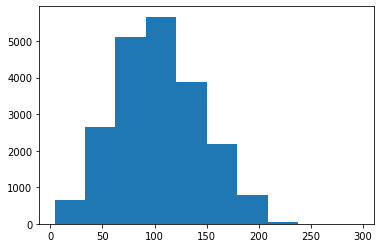

In [ ]:
plt.hist([len(title) for title in train.MERGED])

In [ ]:
max_len_merged = max([len(abstract.split()) for abstract in train.MERGED])
vocab_len = len({word for word_list in train.MERGED for word in word_list.split()})

In [ ]:
print(max_len_merged)
print(vocab_len)

259
50759


In [ ]:
train.drop(['TITLE', 'ABSTRACT'], axis=1, inplace=True)

In [ ]:
max_features = 300000

tvec = TfidfVectorizer(smooth_idf=True, use_idf=True, ngram_range=(1, 3), dtype=np.float32, max_features=max_features)

In [ ]:
X = tvec.fit_transform(train.MERGED)
X.shape

(20972, 300000)

In [ ]:
y = train.iloc[:, :-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [ ]:
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [ ]:
model = create_model(max_features, y)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
y_train = tf.convert_to_tensor(y_train, bool)
y_test = tf.convert_to_tensor(y_test, bool)

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=4, verbose=1)
es = EarlyStopping(patience=5)

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), callbacks=[reduce_lr, es])

Epoch 1/50
156/156 [==============================] - 14s 91ms/step - loss: 0.3846 - accuracy: 0.7063 - val_loss: 0.4339 - val_accuracy: 0.4137
Epoch 2/50
156/156 [==============================] - 14s 90ms/step - loss: 0.1030 - accuracy: 0.8280 - val_loss: 0.2497 - val_accuracy: 0.7931
Epoch 3/50
156/156 [==============================] - 14s 90ms/step - loss: 0.0366 - accuracy: 0.8495 - val_loss: 0.2033 - val_accuracy: 0.8027
Epoch 4/50
156/156 [==============================] - 14s 91ms/step - loss: 0.0168 - accuracy: 0.8511 - val_loss: 0.2511 - val_accuracy: 0.7817
Epoch 5/50
156/156 [==============================] - 14s 91ms/step - loss: 0.0097 - accuracy: 0.8512 - val_loss: 0.2936 - val_accuracy: 0.7722
Epoch 6/50
156/156 [==============================] - 14s 91ms/step - loss: 0.0056 - accuracy: 0.8477 - val_loss: 0.3243 - val_accuracy: 0.7798
Epoch 7/50
156/156 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.8502
Epoch 00007: ReduceLROnPlateau reducing 

This model was giving 82.5% accuracy on the test dataset.